# Construction et évaluation modèle de risque linéaire

## Plan
- [1. Importer Packages](#1)
- [2. Charger données](#2)
- [3. Explorer les données](#3)
- [4. Moyenner-Normaliser les données](#4)
- [5. Construire le modèle](#Ex-2)
- [6. Evaluer le modèle en utilisant le C-Index](#6)
- [7. Evaluer le modèle sur ensemble de test](#7)
- [8. Improver le modèle](#8)
- [9. Evaluer le modèle amélioré](#9)

Dans ce travail, on va construire un modèle de score de risque pour la rétinopathie chez les patients diabétiques à l'aide de la régression logistique.

Au fur et à mesure du développement du modèle, les sujets suivants seront abordés :

- Prétraitement des données
  - Transformations logiques
  - Normalisation
- Modèles de risque de base
  - Régression logistique
  - Index C
  - Termes d'interaction
  
### Rétinopathie diabétique
La rétinopathie est une affection oculaire qui provoque des modifications des vaisseaux sanguins dans la partie de l'œil appelée rétine. Cela entraîne souvent des troubles de la vision ou la cécité. Les patients diabétiques sont connus pour avoir un risque élevé de rétinopathie. 
    
### Régression logistique    
La régression logistique est une analyse appropriée pour prédire la probabilité d'un résultat binaire. Dans notre cas, il s'agirait de la probabilité d'avoir ou non une rétinopathie diabétique.
La régression logistique est l'un des algorithmes les plus couramment utilisés pour la classification binaire. Il permet de trouver le modèle le mieux adapté pour décrire la relation entre un ensemble de caractéristiques (également appelées variables d'entrée, indépendantes, prédictives ou explicatives) et une étiquette de résultat binaire (également appelée variable de sortie, dépendante ou de réponse). La régression logistique a pour propriété que la prédiction de sortie se situe toujours dans l'intervalle $[0,1]$. Cette sortie est parfois utilisée pour représenter une probabilité comprise entre 0 et 100\%, mais dans le cas d'une classification binaire directe, la sortie est convertie en $0$ ou $1$ selon qu'elle est inférieure ou supérieure à un certain seuil, généralement $0.5$.

Il peut être déroutant que le terme régression apparaisse dans le nom alors que la régression logistique est en fait un algorithme de classification, mais c'est juste un nom qui lui a été donné pour des raisons historiques.

<a name='1'></a>
## 1.  Importer des paquets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<a name='2'></a>
## Chargement des données

On va charger l'ensemble de données que l'on va utiliser pour l'entraînement et le test de notre modèle.

In [2]:
X = pd.read_csv('X_data.csv',index_col=0)
y_df = pd.read_csv('y_data.csv',index_col=0)
y = y_df['y']

`X` et `y` sont des DataFrames Pandas qui contiennent les données de 6 000 patients diabétiques. 

<a name='3'></a>
## 3. Explorer l'ensemble de données

Les caractéristiques (`X`) comprennent les champs suivants :
* Âge : (années)
* Systolic_BP : Pression artérielle systolique (mmHg)
* Tension artérielle diastolique : tension artérielle diastolique (mmHg)
* Cholestérol : (mg/DL)
    
On peut utiliser la méthode `head()` pour afficher les premiers enregistrements de chacun.    

In [3]:
X.head()

,Age,Systolic_BP,Diastolic_BP,Cholesterol
0,77.196340,85.288742,80.021878,79.957109
1,63.529850,99.379736,84.852361,110.382411
2,69.003986,111.349455,109.850616,100.828246
3,82.638210,95.056128,79.666851,87.066303
4,78.346286,109.154591,90.713220,92.511770


La cible (`y`) est un indicateur de l'apparition ou non d'une rétinopathie chez le patient.

* y = 1 : le patient a une rétinopathie.
* y = 0 : le patient n'a pas de rétinopathie.

In [4]:
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: y, dtype: float64

Avant de construire un modèle, examinons de plus près la distribution de nos données d'apprentissage. Afin d'y parvenir, ces données seront divisées en ensembles d'apprentissage et de test selon un ratio de 75/25.

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

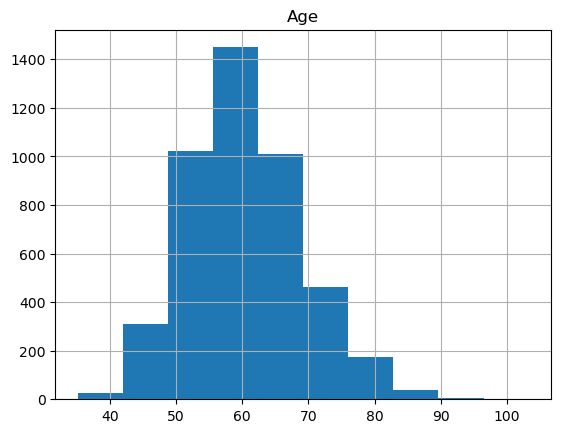

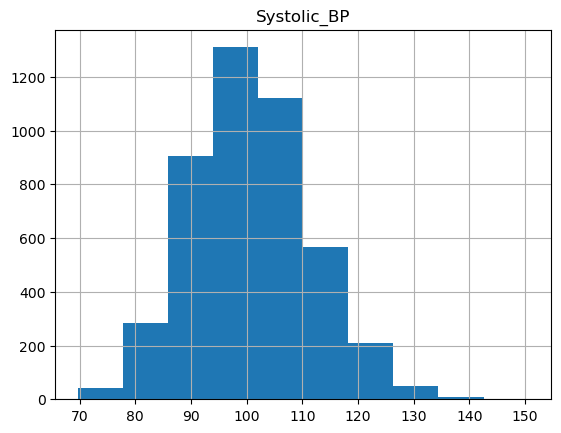

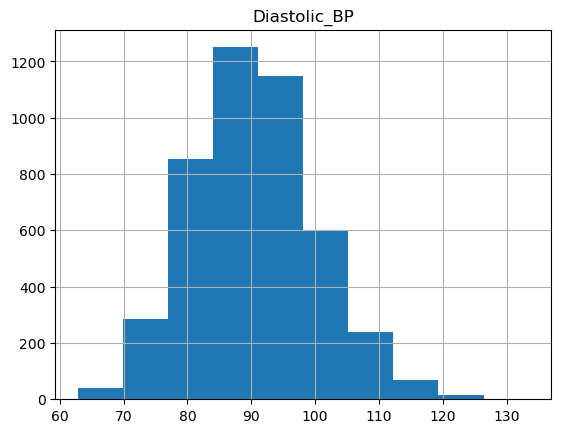

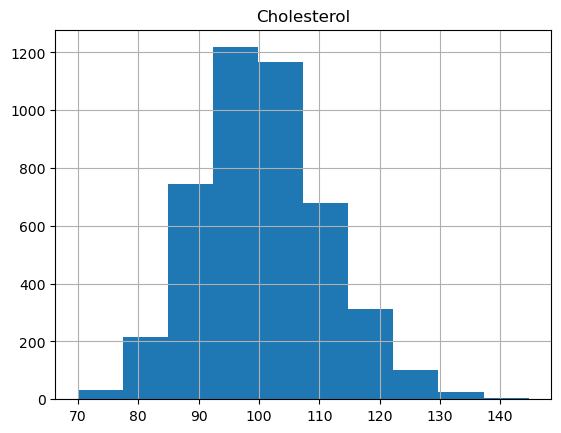

In [7]:
# On peut aussi tracer quelques histogrammes pour avoir une idée de la répartition de nos données
for col in X.columns:
    X_train_raw.loc[:, col].hist()
    plt.title(col)
    plt.show()

Comme on peut le voir, les distributions ont généralement une forme de cloche, mais avec une légère asymétrie vers la droite.

De nombreux modèles statistiques supposent que les données sont normalement distribuées, formant une forme de cloche gaussienne symétrique (sans asymétrie) plus proche de l'exemple ci-dessous.

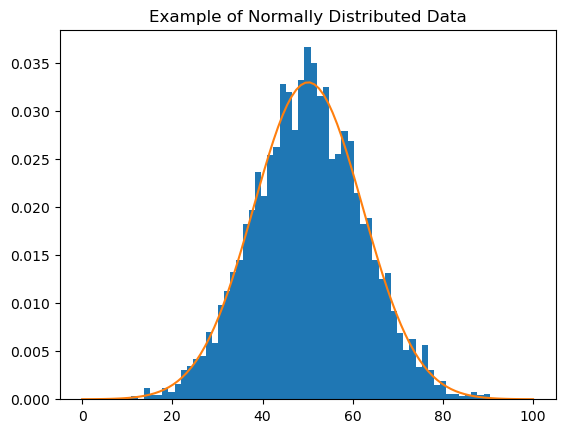

In [8]:
from scipy.stats import norm
data = np.random.normal(50,12, 5000)
fitting_params = norm.fit(data)
norm_dist_fitted = norm(*fitting_params)
t = np.linspace(0,100, 100)
plt.hist(data, bins=60, density=True)
plt.plot(t, norm_dist_fitted.pdf(t))
plt.title('Example of Normally Distributed Data')
plt.show()

On peut transformer nos données pour qu'elles se rapprochent d'une distribution normale en supprimant l'asymétrie. L'une des façons de supprimer l'asymétrie est d'appliquer la fonction logarithmique aux données.

Pour voir si cette méthode produit l'effet désiré, il suffit de tracer le logarithme des variables caractéristiques.

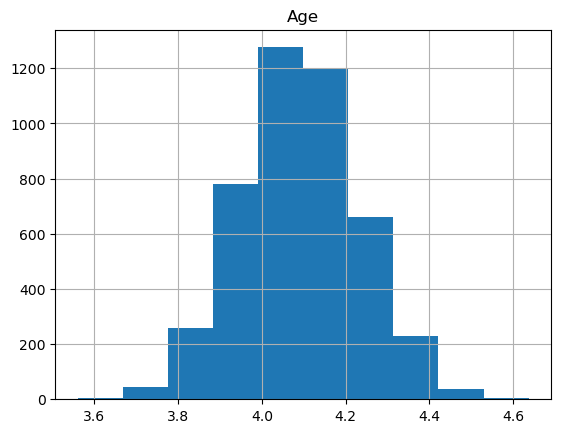

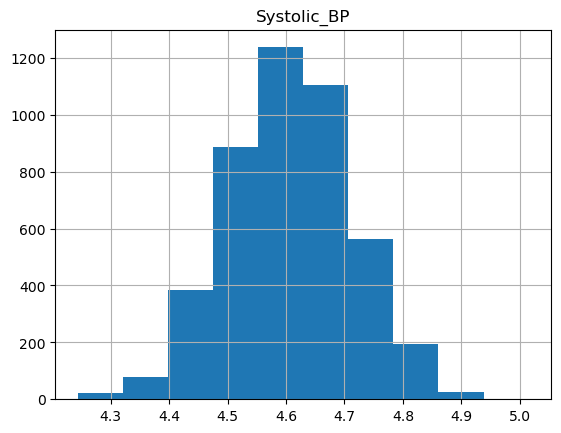

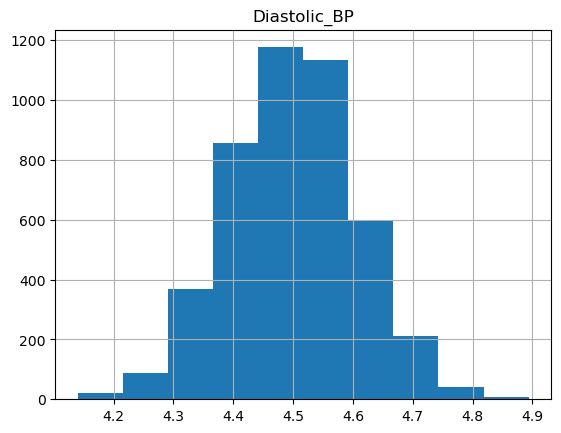

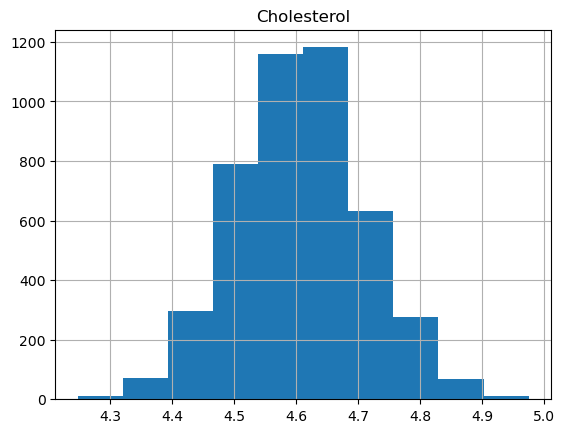

In [9]:
for col in X_train_raw.columns:
    np.log(X_train_raw.loc[:, col]).hist()
    plt.title(col)
    plt.show()

On constate que les données sont plus symétriques après avoir pris le logarithme.

<a name='4'></a>
## 4. Normalisation de la moyenne des données

À présent, il faut transformer nos données pour que les distributions soient plus proches des distributions normales standard.

Tout d'abord, on va supprimer une partie de l'asymétrie de la distribution en utilisant la transformation logarithmique.
Ensuite, en "normalisant" la distribution, on lui donne une moyenne de zéro et un écart-type de 1.

In [14]:
def make_standard_normal(df_train, df_test):
    df_train_unskewed = np.log(df_train)
    df_test_unskewed = np.log(df_test)
    
    mean = df_train_unskewed.mean(axis = 0)
    stdev = df_train_unskewed.std(axis = 0)
    
    df_train_standardized = (df_train_unskewed - mean)/ stdev
    
    df_test_standardized = (df_test_unskewed - mean) / stdev
    
    return df_train_standardized, df_test_standardized

In [15]:
# test
tmp_train = pd.DataFrame({'field1': [1,2,10], 'field2': [4,5,11]})
tmp_test = pd.DataFrame({'field1': [1,3,10], 'field2': [4,6,11]})
tmp_train_transformed, tmp_test_transformed = make_standard_normal(tmp_train,tmp_test)

print(f"Ensemble apprentissage transformé field1 a une moyenne {tmp_train_transformed['field1'].mean(axis=0):.4f} et écart type {tmp_train_transformed['field1'].std(axis=0):.4f} ")
print(f"Ensemble test transformé, field 1 a une moyenne {tmp_test_transformed['field1'].mean(axis=0):.4f}  et écart type {tmp_test_transformed['field1'].std(axis=0):.4f}")
print(f"Déséquilibre ensemble apprentissage field1 avant transformation: {tmp_train['field1'].skew(axis=0):.4f}")
print(f"Déséquilibre ensemble apprentissage field1 après transformation: {tmp_train_transformed['field1'].skew(axis=0):.4f}")
print(f"Déséquilibre ensemble test field1 avant transformation: {tmp_test['field1'].skew(axis=0):.4f}")
print(f"Déséquilibre ensemble test field1 avant transformation: {tmp_test_transformed['field1'].skew(axis=0):.4f}")

Ensemble apprentissage transformé field1 a une moyenne -0.0000 et écart type 1.0000 
Ensemble test transformé, field 1 a une moyenne 0.1144  et écart type 0.9749
Déséquilibre ensemble apprentissage field1 avant transformation: 1.6523
Déséquilibre ensemble apprentissage field1 après transformation: 1.0857
Déséquilibre ensemble test field1 avant transformation: 1.3896
Déséquilibre ensemble test field1 avant transformation: 0.1371


In [16]:
X_train, X_test = make_standard_normal(X_train_raw, X_test_raw)

Après avoir transformé les ensembles de formation et de test, on s'attend à ce que l'ensemble de formation soit centré sur zéro avec un écart type de $1$.

Pour ne pas fausser le processus d'apprentissage du modèle, on évitera d'observer l'ensemble de test pendant l'apprentissage du modèle, mais on pourra tout de même examiner les distributions des données d'apprentissage transformées.

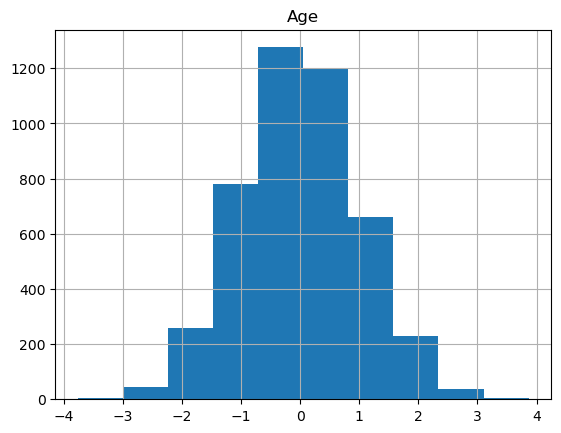

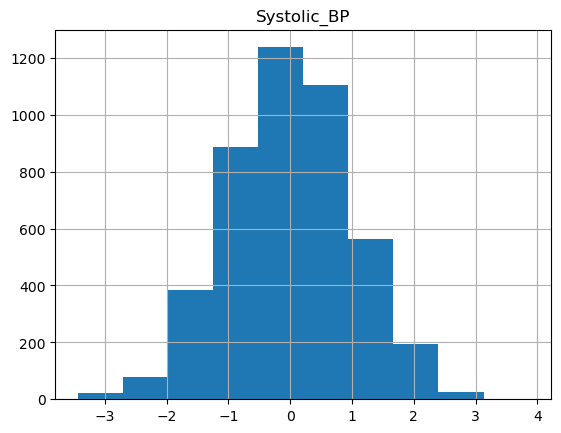

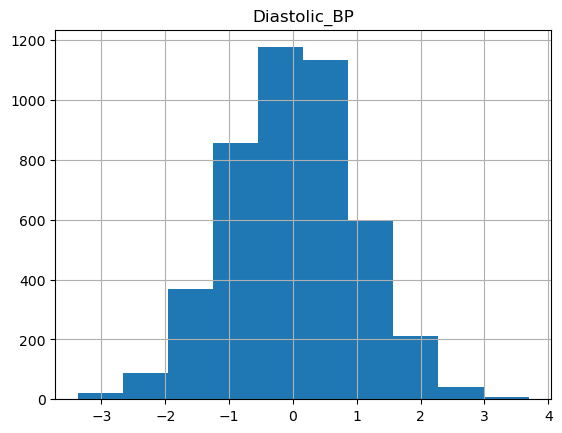

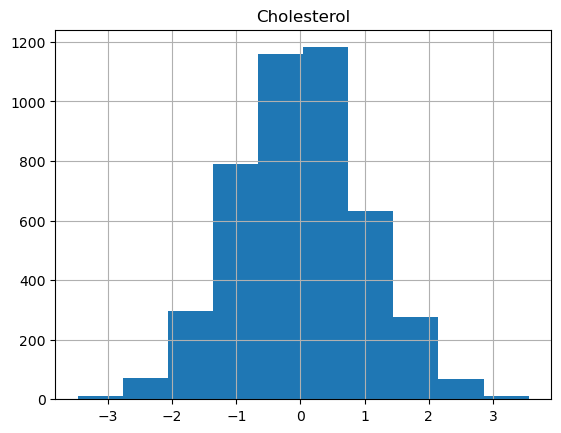

In [17]:
for col in X_train.columns:
    X_train[col].hist()
    plt.title(col)
    plt.show()

<a name='5'></a>
## 5. Contruction du modèle

À présent, le modèle de risque est prêt à être construit en entraînant la régression logistique à l'aide de nos données.

In [18]:
def lr_model(X_train, y_train):
    
    from sklearn.linear_model import LogisticRegression
    
    model = LogisticRegression(solver='lbfgs')
    
    model.fit(X_train, y_train)
    
    return model

In [19]:
# Test
tmp_model = lr_model(X_train[0:3], y_train[0:3] )
print(tmp_model.predict(X_train[4:5]))
print(tmp_model.predict(X_train[5:6]))

[1.]
[1.]


Maintenant que nous avons testé notre modèle, nous pouvons le construire. Notez que la fonction `lr_model` ajuste également le modèle aux données d'entraînement.

In [20]:
model_X = lr_model(X_train, y_train)

<a name='6'></a>
## 6. Evaluation du modèle avec le C-index

Maintenant que nous avons un modèle, nous devons l'évaluer. Pour ce faire, nous utiliserons l'indice c. 
* L'indice c mesure le pouvoir discriminatoire d'un score de risque. 
* Intuitivement, un indice c élevé indique que la prédiction du modèle est en accord avec les résultats réels d'une paire de patients.

* Une paire admissible est une paire de patients qui ont des résultats différents.
* Une paire concordante est une paire autorisée dans laquelle le patient ayant le score de risque le plus élevé a également le plus mauvais résultat.
* Une paire concordante est une paire autorisée dans laquelle les patients ont le même score de risque.

In [21]:
def cindex(y_true, scores):
    n = len(y_true)
    assert len(scores) == n

    concordant = 0
    permissible = 0
    ties = 0
    
    for i in range(n):
        for j in range(i+1, n):
            
            if y_true[i] != y_true[j]:
                permissible += 1

                if scores[i] == scores[j]:
                    ties += 1
                    continue

                if y_true[i] == 0 and y_true[j] == 1:
                    if scores[i] < scores[j]:
                        concordant += 1

                if y_true[i] == 1 and y_true[j] == 0:
                    if scores[i] > scores[j]:
                        concordant += 1
                    
    c_index = (concordant + 0.5 * ties) / permissible
    
    return c_index

#### Test


In [22]:
# test
y_true = np.array([1.0, 0.0, 0.0, 1.0])

# Cas 1
scores = np.array([0, 1, 1, 0])
print('Cas 1 Résultat: {}'.format(cindex(y_true, scores)))

# Case 2
scores = np.array([1, 0, 0, 1])
print('Cas 1 Résultat: {}'.format(cindex(y_true, scores)))

# Case 3
scores = np.array([0.5, 0.5, 0.0, 1.0])
print('Cas 3 Résultat: {}'.format(cindex(y_true, scores)))
cindex(y_true, scores)

Cas 1 Résultat: 0.0
Cas 1 Résultat: 1.0
Cas 3 Résultat: 0.875


0.875

<a name='7'></a>
## 7. Evaluation du modéle sur l'ensemble de test

In [23]:
scores = model_X.predict_proba(X_test)[:, 1]
c_index_X_test = cindex(y_test.values, scores)
print(f"c-index sur ensemble test est {c_index_X_test:.4f}")

c-index sur ensemble test est 0.8182


Traçons les coefficients pour voir quelles variables (caractéristiques du patient) ont le plus d'effet.

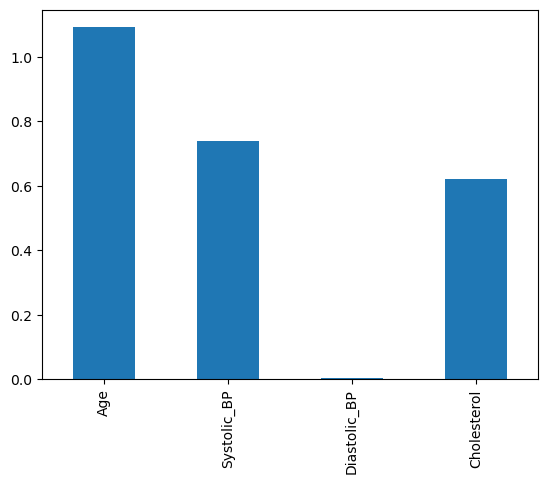

In [24]:
coeffs = pd.DataFrame(data = model_X.coef_, columns = X_train.columns)
coeffs.T.plot.bar(legend=None);

<a name='8'></a>
## 8. Améliorer le modèle

Vous pouvez essayer d'améliorer votre modèle en incluant des termes d'interaction. 
* Un terme d'interaction est le produit de deux variables. 
    * Par exemple, si nous avons des données 
    $$ x = [x_1, x_2]$$
    * Nous pourrions ajouter le produit de sorte que :
    $$ \hat{x} = [x_1, x_2, x_1*x_2]$$
    

In [25]:
def add_interactions(X):
    features = X.columns
    m = len(features)
    X_int = X.copy(deep=True)

    for i in range(m-1):
        
        feature_i_name = features[i]
        
        feature_i_data = X[feature_i_name]
        
        for j in range(i+1, m):
            
            feature_j_name = features[j]
            
            feature_j_data = X[feature_j_name]
            
            feature_i_j_name = feature_i_name + "_x_" + feature_j_name
            
            X_int[feature_i_j_name] = feature_i_data * feature_j_data
        
    
    return X_int

#### Test

In [26]:
print("Données origine")
print(X_train.loc[:, ['Age', 'Systolic_BP']].head())
print("Données w/ Interactions")
print(add_interactions(X_train.loc[:, ['Age', 'Systolic_BP']].head()))

Données origine
           Age  Systolic_BP
1824 -0.912451    -0.068019
253  -0.302039     1.719538
1114  2.576274     0.155962
3220  1.163621    -2.033931
2108 -0.446238    -0.054554
Données w/ Interactions
           Age  Systolic_BP  Age_x_Systolic_BP
1824 -0.912451    -0.068019           0.062064
253  -0.302039     1.719538          -0.519367
1114  2.576274     0.155962           0.401800
3220  1.163621    -2.033931          -2.366725
2108 -0.446238    -0.054554           0.024344


In [27]:
X_train_int = add_interactions(X_train)
X_test_int = add_interactions(X_test)

<a name='9'></a>
## 9. Évaluation du modèle amélioré

On peut maintenant entraîner la nouvelle version améliorée du modèle.

In [28]:
model_X_int = lr_model(X_train_int, y_train)

Évaluons notre nouveau modèle sur l'ensemble de tests.

In [29]:
scores_X = model_X.predict_proba(X_test)[:, 1]
c_index_X_int_test = cindex(y_test.values, scores_X)

scores_X_int = model_X_int.predict_proba(X_test_int)[:, 1]
c_index_X_int_test = cindex(y_test.values, scores_X_int)

print(f"c-index sur ensemble test sans interactions  {c_index_X_test:.4f}")
print(f"c-index sur ensemble test avec interactions  {c_index_X_int_test:.4f}")

c-index sur ensemble test sans interactions  0.8182
c-index sur ensemble test avec interactions  0.8281


Le modèle avec des termes d'interaction est un peu plus performant que le modèle sans interactions.

Examinons à nouveau les coefficients du modèle pour essayer de voir quelles variables ont fait la différence. Tracez les coefficients et indiquez les caractéristiques qui semblent les plus importantes.

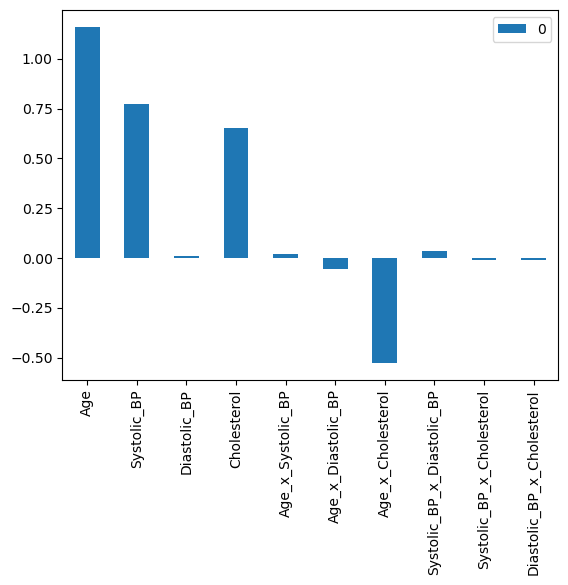

In [30]:
int_coeffs = pd.DataFrame(data = model_X_int.coef_, columns = X_train_int.columns)
int_coeffs.T.plot.bar();

### Questions :
> __Quelles sont les variables les plus importantes pour le modèle?__<br>
> __Les variables pertinentes ont-elles changé?__<br>
> __Que signifie le fait que les coefficients soient positifs ou négatifs?__<br>

Vous pouvez remarquer que l'âge, la pression systolique et le cholestérol ont un coefficient positif. Cela signifie qu'une valeur plus élevée de ces trois caractéristiques entraîne une probabilité de prédiction plus élevée pour la maladie. Vous pouvez également remarquer que l'interaction entre l'âge et le cholestérol a un coefficient négatif. Cela signifie qu'une valeur plus élevée du produit Âge x Cholestérol réduit la probabilité de prédiction de la maladie.

Pour comprendre l'effet des termes d'interaction, comparons la sortie du modèle que nous avons formé sur des échantillons de cas avec et sans interaction.

In [31]:
index = index = 3432
case = X_train_int.iloc[index, :]
print(case)

Age                           2.502061
Systolic_BP                   1.713547
Diastolic_BP                  0.268265
Cholesterol                   2.146349
Age_x_Systolic_BP             4.287400
Age_x_Diastolic_BP            0.671216
Age_x_Cholesterol             5.370296
Systolic_BP_x_Diastolic_BP    0.459685
Systolic_BP_x_Cholesterol     3.677871
Diastolic_BP_x_Cholesterol    0.575791
Name: 5970, dtype: float64


Nous pouvons voir qu'ils ont un âge et un taux de cholestérol supérieurs à la moyenne. Nous pouvons maintenant voir ce que notre modèle original aurait produit en mettant à zéro la valeur du cholestérol et de l'âge.

In [32]:
new_case = case.copy(deep=True)
new_case.loc["Age_x_Cholesterol"] = 0
new_case

Age                           2.502061
Systolic_BP                   1.713547
Diastolic_BP                  0.268265
Cholesterol                   2.146349
Age_x_Systolic_BP             4.287400
Age_x_Diastolic_BP            0.671216
Age_x_Cholesterol             0.000000
Systolic_BP_x_Diastolic_BP    0.459685
Systolic_BP_x_Cholesterol     3.677871
Diastolic_BP_x_Cholesterol    0.575791
Name: 5970, dtype: float64

In [33]:
print(f"Sortie avec interaction: \t{model_X_int.predict_proba([case.values])[:, 1][0]:.4f}")
print(f"Sortie sans interaction: \t{model_X_int.predict_proba([new_case.values])[:, 1][0]:.4f}")

Sortie avec interaction: 	0.9448
Sortie sans interaction: 	0.9965


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Nous constatons que le modèle est moins confiant dans sa prédiction avec le terme d'interaction que sans (la valeur de prédiction est plus faible lorsque le terme d'interaction est inclus). Avec le terme d'interaction, le modèle s'est ajusté au fait que l'effet de l'hypercholestérolémie devient moins important pour les patients plus âgés que pour les patients plus jeunes.